In [11]:
import shap
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [12]:
data1 = pd.read_csv('diabetes.csv',header=None)
le = LabelEncoder()
data1.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
print(data1.columns)
data1['Outcome'] = le.fit_transform(data1['Outcome'])

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


In [13]:
X = data1.drop('Outcome', axis=1)
y = data1['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
explainer = shap.TreeExplainer(model)   
shap_values = explainer.shap_values(X_test)

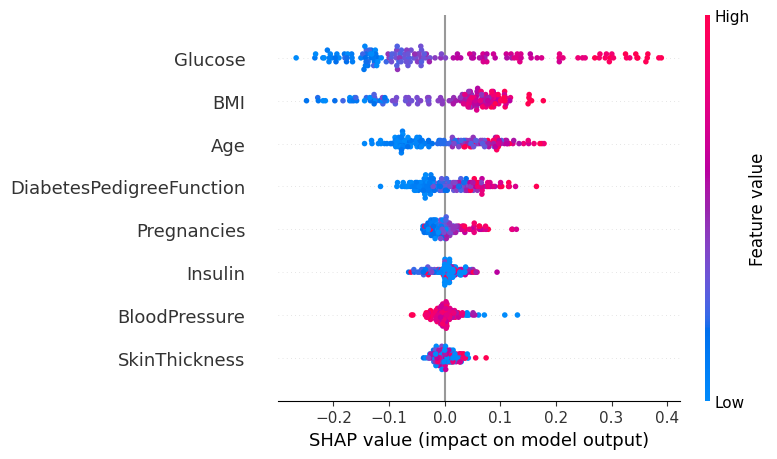

In [14]:
shap.summary_plot(shap_values[:,:,1], X_test)

In [15]:
shap_values_pos = shap_values[:, :, 1]   # shape: (154, 8)

# Sum SHAP contributions per sample
shap_sum = shap_values_pos.sum(axis=1)   # shape: (154,)

# Model predicted probabilities for positive class
preds = model.predict_proba(X_test)[:, 1]  # shape: (154,)

# Compute correlation between SHAP sum and model prediction (fidelity)
fidelity = np.corrcoef(preds, shap_sum)[0, 1]
print("Fidelity (correlation between SHAP and model predictions):", round(fidelity, 3))

Fidelity (correlation between SHAP and model predictions): 1.0


In [21]:
def stability_score(explainer, sample, n_perturb=5, noise=0.01):
    shap_vals = explainer.shap_values(sample)
    
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    
    base = shap_vals[0, :, 1].flatten() 
    similarities = []
    
    for _ in range(n_perturb):
        perturbed = sample + np.random.normal(0, noise, sample.shape)
        shap_pert = explainer.shap_values(perturbed)
        if isinstance(shap_pert, list):
            shap_pert = shap_pert[1]
        pert_vals = shap_pert[0, :, 1].flatten()
        cos_sim = np.dot(base, pert_vals) / (np.linalg.norm(base) * np.linalg.norm(pert_vals))
        similarities.append(cos_sim)
    
    return np.mean(similarities)


sample = X_test.iloc[:1].values
stability = stability_score(explainer, sample)
print("Stability (average cosine similarity):", round(stability, 3))

Stability (average cosine similarity): 0.999


In [32]:
start = time.time()
explainer.shap_values(X_test[:50])
end = time.time()

runtime = end - start
print("Efficiency (seconds for 50 samples):", round(runtime, 3))


Efficiency (seconds for 50 samples): 0.161
